## Install necessary libraries

In [ ]:
!pip install efficientnet-pytorch
!pip install tqdm

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=5ffb5ff0123929f6649a96967a8382f6744c119741bf6778a145e427df027d32
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet-pytorch


## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import zipfile
from PIL import Image
from tqdm.notebook import tqdm

from efficientnet_pytorch import EfficientNet
from google.colab import drive
import pickle

## Mount Google Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
DRIVE_PATH = '/content/drive/MyDrive/AML Data/'
TRAIN_ZIP_PATH = DRIVE_PATH + 'Train.zip'
TEST_ZIP_PATH = DRIVE_PATH + 'Test.zip'
TRAIN_ANNOTATIONS = DRIVE_PATH + 'train.txt'
TEST_ANNOTATIONS = DRIVE_PATH + 'test.txt'
WEIGHTS_PATH = DRIVE_PATH + 'model_weights_efficientnet-b0.pth'
RESULTS_PATH = DRIVE_PATH + 'results/'

# Create results directory
os.makedirs(RESULTS_PATH, exist_ok=True)

Mounted at /content/drive


## Extract & Define Dataset

In [ ]:
# Extract datasets
def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Extracted {zip_path} to {extract_to}")

extract_zip(TRAIN_ZIP_PATH, '/content/train_images/')
extract_zip(TEST_ZIP_PATH, '/content/test_images/')

Extracted /content/drive/MyDrive/AML Data/Train.zip to /content/train_images/
Extracted /content/drive/MyDrive/AML Data/Test.zip to /content/test_images/


In [ ]:
# Custom Dataset Class
class BirdDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file, sep=' ', header=None, names=['filename', 'label'])
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

## Data Preprocessing

In [ ]:
# Data Augmentation and Preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test transform remains the same
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# --- Load datasets ---
train_dataset = BirdDataset(TRAIN_ANNOTATIONS, '/content/train_images/Train/', transform=train_transform)
test_dataset = BirdDataset(TEST_ANNOTATIONS, '/content/test_images/Test/', transform=test_transform)

# Use test set as validation
val_dataset = test_dataset

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples (formerly 'test'): {len(val_dataset)}")

Train samples: 4829
Validation samples (formerly 'test'): 1204


In [ ]:
# Data Loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Define Model

In [ ]:
# Model Definition with Layer Freezing Support
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, mode='max'):  # mode='max' for accuracy
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.mode = mode

    def __call__(self, val_metric):
        score = val_metric if self.mode == 'max' else -val_metric

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = score
            self.counter = 0
        return False

class BirdClassifier(nn.Module):
    def __init__(self, num_classes=200, freeze_backbone=True):
        super(BirdClassifier, self).__init__()
        # Load pretrained EfficientNet-B0
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

        # Freeze backbone layers if specified
        if freeze_backbone:
            for param in self.efficientnet.parameters():
                param.requires_grad = False
            # Only unfreeze the last few layers
            for param in self.efficientnet._blocks[-3:].parameters():
                param.requires_grad = True

        # Replace the final classifier
        in_features = self.efficientnet._fc.in_features
        self.efficientnet._fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def unfreeze_all(self):
        for param in self.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.efficientnet(x)

In [ ]:
# Initialize model with frozen backbone
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BirdClassifier(num_classes=200, freeze_backbone=True).to(device)  # Start with frozen backbone

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.05) # Label smoothing
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold=0.2, threshold_mode='abs', min_lr=0.0000001)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Using device: cuda
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


100%|██████████| 20.4M/20.4M [00:00<00:00, 39.1MB/s]


Loaded pretrained weights for efficientnet-b0
Model initialized with 4847684 parameters
Trainable parameters: 2733272


## Training Functions

In [ ]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc='Training')
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    return running_loss / len(train_loader), 100. * correct / total

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validation')
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            progress_bar.set_postfix({
                'Loss': f'{val_loss/len(val_loader):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    return val_loss / len(val_loader), 100. * correct / total

In [ ]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, early_stopping=None):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    learning_rates = []

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        # Learning rate scheduling
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_acc)
        new_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(new_lr)

        if new_lr < old_lr:
            print(f"Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}")

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {new_lr:.6f}')

        # Calculate and monitor overfitting gap
        gap = train_acc - val_acc
        print(f'Train-Val Gap: {gap:.2f}%')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
                'learning_rates': learning_rates
            }, WEIGHTS_PATH)
            print(f'New best model saved with validation accuracy: {best_val_acc:.2f}%')

        # Early stopping check
        if early_stopping and early_stopping(val_acc):
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    return train_losses, val_losses, train_accuracies, val_accuracies, learning_rates

## Model Training

In [ ]:
# Two-stage training with early stopping
print("=== Stage 1: Training with frozen backbone ===")
early_stopping = EarlyStopping(patience=5, min_delta=0.1, mode='max')

train_losses_1, val_losses_1, train_acc_1, val_acc_1, lr_1 = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=15,
    early_stopping=early_stopping
)

# Load best Stage 1 weights
ckpt = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(ckpt['model_state_dict'])

print("\n=== Stage 2: Unfreeze layers===")
# Unfreeze all layers and use lower learning rate
model.unfreeze_all()
optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3)

# Reset early stopping for second stage
early_stopping = EarlyStopping(patience=8, min_delta=0.5)

train_losses_2, val_losses_2, train_acc_2, val_acc_2, lr_2 = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=30, early_stopping=early_stopping
)

# Combine training history from both stages
train_losses = train_losses_1 + train_losses_2
val_losses = val_losses_1 + val_losses_2
train_accuracies = train_acc_1 + train_acc_2
val_accuracies = val_acc_1 + val_acc_2
learning_rates = lr_1 + lr_2

print(f"\nTraining completed! Total epochs: {len(train_losses)}")

=== Stage 1: Training with frozen backbone ===

Epoch 1/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 5.2055, Train Acc: 2.33%
Val Loss: 4.5070, Val Acc: 13.46%
Learning Rate: 0.000500
Train-Val Gap: -11.12%
New best model saved with validation accuracy: 13.46%

Epoch 2/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 4.4113, Train Acc: 10.04%
Val Loss: 3.7354, Val Acc: 23.75%
Learning Rate: 0.000500
Train-Val Gap: -13.71%
New best model saved with validation accuracy: 23.75%

Epoch 3/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 3.7135, Train Acc: 19.90%
Val Loss: 3.1581, Val Acc: 34.97%
Learning Rate: 0.000500
Train-Val Gap: -15.07%
New best model saved with validation accuracy: 34.97%

Epoch 4/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 3.2290, Train Acc: 29.94%
Val Loss: 2.7613, Val Acc: 40.86%
Learning Rate: 0.000500
Train-Val Gap: -10.93%
New best model saved with validation accuracy: 40.86%

Epoch 5/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 2.8379, Train Acc: 37.71%
Val Loss: 2.5020, Val Acc: 46.59%
Learning Rate: 0.000500
Train-Val Gap: -8.89%
New best model saved with validation accuracy: 46.59%

Epoch 6/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 2.5668, Train Acc: 43.00%
Val Loss: 2.3058, Val Acc: 52.41%
Learning Rate: 0.000500
Train-Val Gap: -9.41%
New best model saved with validation accuracy: 52.41%

Epoch 7/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 2.3378, Train Acc: 49.08%
Val Loss: 2.2184, Val Acc: 53.32%
Learning Rate: 0.000500
Train-Val Gap: -4.24%
New best model saved with validation accuracy: 53.32%

Epoch 8/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 2.1582, Train Acc: 53.06%
Val Loss: 2.0861, Val Acc: 55.48%
Learning Rate: 0.000500
Train-Val Gap: -2.42%
New best model saved with validation accuracy: 55.48%

Epoch 9/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 2.0090, Train Acc: 57.94%
Val Loss: 2.0463, Val Acc: 56.15%
Learning Rate: 0.000500
Train-Val Gap: 1.79%
New best model saved with validation accuracy: 56.15%

Epoch 10/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.8807, Train Acc: 61.35%
Val Loss: 2.0020, Val Acc: 59.39%
Learning Rate: 0.000500
Train-Val Gap: 1.97%
New best model saved with validation accuracy: 59.39%

Epoch 11/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.7483, Train Acc: 65.23%
Val Loss: 1.9639, Val Acc: 60.63%
Learning Rate: 0.000500
Train-Val Gap: 4.60%
New best model saved with validation accuracy: 60.63%

Epoch 12/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.6310, Train Acc: 68.27%
Val Loss: 1.9459, Val Acc: 61.05%
Learning Rate: 0.000500
Train-Val Gap: 7.22%
New best model saved with validation accuracy: 61.05%

Epoch 13/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.5769, Train Acc: 70.08%
Val Loss: 1.9055, Val Acc: 61.38%
Learning Rate: 0.000500
Train-Val Gap: 8.70%
New best model saved with validation accuracy: 61.38%

Epoch 14/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.4856, Train Acc: 73.19%
Val Loss: 1.9057, Val Acc: 62.38%
Learning Rate: 0.000500
Train-Val Gap: 10.81%
New best model saved with validation accuracy: 62.38%

Epoch 15/15
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.4559, Train Acc: 73.67%
Val Loss: 1.8999, Val Acc: 61.71%
Learning Rate: 0.000500
Train-Val Gap: 11.96%

=== Stage 2: Progressive fine-tuning with gradual unfreezing ===

Epoch 1/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.3978, Train Acc: 76.46%
Val Loss: 1.8464, Val Acc: 64.12%
Learning Rate: 0.000010
Train-Val Gap: 12.34%
New best model saved with validation accuracy: 64.12%

Epoch 2/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.3299, Train Acc: 78.73%
Val Loss: 1.8170, Val Acc: 64.12%
Learning Rate: 0.000010
Train-Val Gap: 14.61%

Epoch 3/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.3387, Train Acc: 77.48%
Val Loss: 1.7935, Val Acc: 65.28%
Learning Rate: 0.000010
Train-Val Gap: 12.20%
New best model saved with validation accuracy: 65.28%

Epoch 4/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.3137, Train Acc: 79.04%
Val Loss: 1.7836, Val Acc: 64.95%
Learning Rate: 0.000010
Train-Val Gap: 14.09%

Epoch 5/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.2967, Train Acc: 79.27%
Val Loss: 1.7705, Val Acc: 64.95%
Learning Rate: 0.000010
Train-Val Gap: 14.32%

Epoch 6/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.2647, Train Acc: 81.21%
Val Loss: 1.7679, Val Acc: 65.12%
Learning Rate: 0.000010
Train-Val Gap: 16.09%

Epoch 7/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.2561, Train Acc: 81.25%
Val Loss: 1.7608, Val Acc: 65.70%
Learning Rate: 0.000010
Train-Val Gap: 15.55%
New best model saved with validation accuracy: 65.70%

Epoch 8/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.2691, Train Acc: 80.85%
Val Loss: 1.7521, Val Acc: 65.78%
Learning Rate: 0.000010
Train-Val Gap: 15.07%
New best model saved with validation accuracy: 65.78%

Epoch 9/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.2475, Train Acc: 81.35%
Val Loss: 1.7447, Val Acc: 65.37%
Learning Rate: 0.000010
Train-Val Gap: 15.99%

Epoch 10/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.2355, Train Acc: 82.10%
Val Loss: 1.7382, Val Acc: 65.78%
Learning Rate: 0.000010
Train-Val Gap: 16.32%

Epoch 11/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.2373, Train Acc: 82.44%
Val Loss: 1.7385, Val Acc: 65.78%
Learning Rate: 0.000010
Train-Val Gap: 16.66%

Epoch 12/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.2074, Train Acc: 83.02%
Val Loss: 1.7292, Val Acc: 65.86%
Learning Rate: 0.000010
Train-Val Gap: 17.16%
New best model saved with validation accuracy: 65.86%

Epoch 13/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.2131, Train Acc: 82.67%
Val Loss: 1.7239, Val Acc: 66.20%
Learning Rate: 0.000010
Train-Val Gap: 16.47%
New best model saved with validation accuracy: 66.20%

Epoch 14/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.1984, Train Acc: 83.25%
Val Loss: 1.7198, Val Acc: 65.86%
Learning Rate: 0.000010
Train-Val Gap: 17.39%

Epoch 15/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.1999, Train Acc: 83.73%
Val Loss: 1.7157, Val Acc: 66.20%
Learning Rate: 0.000010
Train-Val Gap: 17.53%

Epoch 16/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.1763, Train Acc: 83.52%
Val Loss: 1.7092, Val Acc: 65.78%
Learning Rate: 0.000010
Train-Val Gap: 17.74%

Epoch 17/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Learning rate reduced from 0.000010 to 0.000002
Train Loss: 1.1778, Train Acc: 84.42%
Val Loss: 1.7097, Val Acc: 65.86%
Learning Rate: 0.000002
Train-Val Gap: 18.55%

Epoch 18/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.1761, Train Acc: 84.12%
Val Loss: 1.7086, Val Acc: 65.95%
Learning Rate: 0.000002
Train-Val Gap: 18.18%

Epoch 19/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.1660, Train Acc: 84.81%
Val Loss: 1.7061, Val Acc: 66.53%
Learning Rate: 0.000002
Train-Val Gap: 18.28%
New best model saved with validation accuracy: 66.53%

Epoch 20/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.1737, Train Acc: 84.44%
Val Loss: 1.7076, Val Acc: 66.94%
Learning Rate: 0.000002
Train-Val Gap: 17.49%
New best model saved with validation accuracy: 66.94%

Epoch 21/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.1670, Train Acc: 84.52%
Val Loss: 1.7037, Val Acc: 66.61%
Learning Rate: 0.000002
Train-Val Gap: 17.91%

Epoch 22/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.1788, Train Acc: 83.94%
Val Loss: 1.7046, Val Acc: 66.86%
Learning Rate: 0.000002
Train-Val Gap: 17.08%

Epoch 23/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.1750, Train Acc: 84.06%
Val Loss: 1.7014, Val Acc: 66.78%
Learning Rate: 0.000002
Train-Val Gap: 17.29%

Epoch 24/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Learning rate reduced from 0.000002 to 0.000000
Train Loss: 1.1719, Train Acc: 84.12%
Val Loss: 1.6971, Val Acc: 66.36%
Learning Rate: 0.000000
Train-Val Gap: 17.76%

Epoch 25/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.1713, Train Acc: 83.73%
Val Loss: 1.7056, Val Acc: 66.28%
Learning Rate: 0.000000
Train-Val Gap: 17.45%

Epoch 26/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.1669, Train Acc: 84.60%
Val Loss: 1.6978, Val Acc: 66.36%
Learning Rate: 0.000000
Train-Val Gap: 18.24%

Epoch 27/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 1.1618, Train Acc: 84.88%
Val Loss: 1.7024, Val Acc: 66.28%
Learning Rate: 0.000000
Train-Val Gap: 18.60%

Epoch 28/30
----------


Training:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Learning rate reduced from 0.000000 to 0.000000
Train Loss: 1.1592, Train Acc: 84.69%
Val Loss: 1.7017, Val Acc: 66.69%
Learning Rate: 0.000000
Train-Val Gap: 17.99%
Early stopping triggered after 28 epochs

Training completed! Total epochs: 43


## Model Evaluation

In [ ]:
# Load best model for evaluation
checkpoint = torch.load(WEIGHTS_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model with validation accuracy: {checkpoint['best_val_acc']:.2f}%")

Loaded best model with validation accuracy: 66.94%


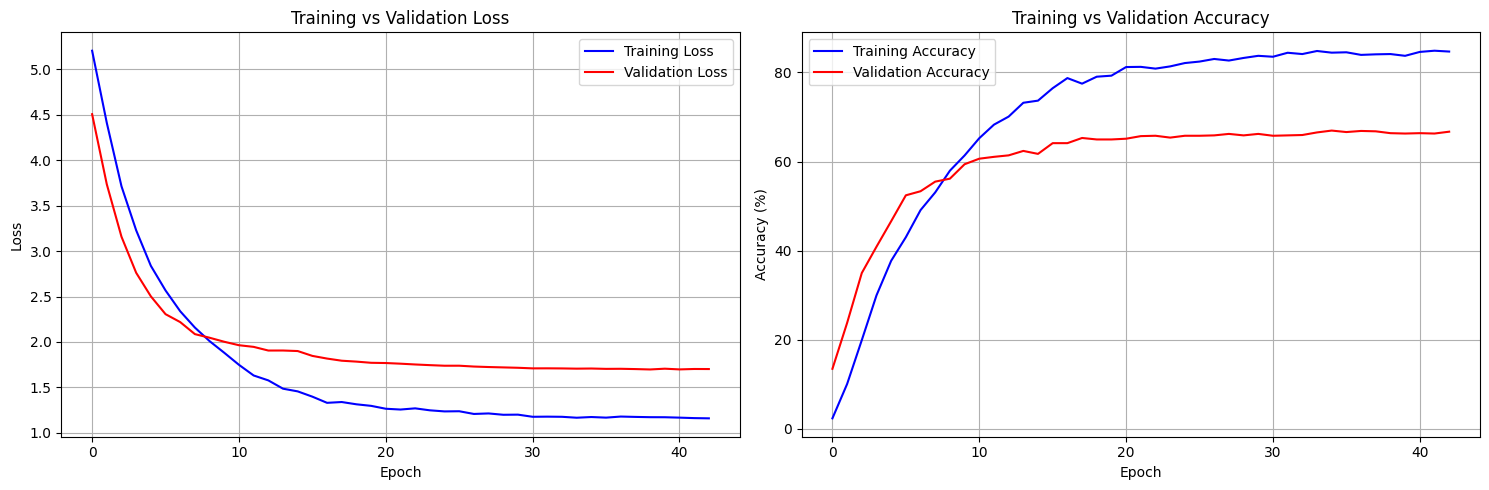

In [ ]:
# Plotting training curves
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training vs Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Training vs Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(RESULTS_PATH + 'training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
# Test evaluation
def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Testing')
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)
            output = model(data)

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

            progress_bar.set_postfix({'Acc': f'{100.*correct/total:.2f}%'})

    top1_accuracy = 100. * correct / total
    return top1_accuracy, all_preds, all_labels

# Calculate average accuracy per class
def calculate_per_class_accuracy(predictions, labels, num_classes=200):
    per_class_acc = []
    for class_id in range(num_classes):
        class_mask = np.array(labels) == class_id
        if np.sum(class_mask) > 0:
            class_correct = np.sum((np.array(predictions)[class_mask] == class_id))
            class_total = np.sum(class_mask)
            class_acc = class_correct / class_total
            per_class_acc.append(class_acc)
        else:
            per_class_acc.append(0.0)  # No samples for this class

    return np.mean(per_class_acc) * 100

In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
test_accuracy, test_preds, test_labels = evaluate_model(model, val_loader, device)

avg_per_class_acc = calculate_per_class_accuracy(test_preds, test_labels)

print(f"\n=== FINAL RESULTS ===")
print(f"Top-1 Accuracy: {test_accuracy:.2f}%")
print(f"Average Accuracy per Class: {avg_per_class_acc:.2f}%")

Evaluating on test set...


Testing:   0%|          | 0/38 [00:00<?, ?it/s]


=== FINAL RESULTS ===
Top-1 Accuracy: 66.94%
Average Accuracy per Class: 66.14%


In [ ]:
# Save results
results = {
    'top1_accuracy': test_accuracy,
    'avg_per_class_accuracy': avg_per_class_acc,
    'predictions': test_preds,
    'true_labels': test_labels,
    'training_history': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }
}

with open(RESULTS_PATH + 'results.pkl', 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to {RESULTS_PATH}")

Results saved to /content/drive/MyDrive/AML Data/results/


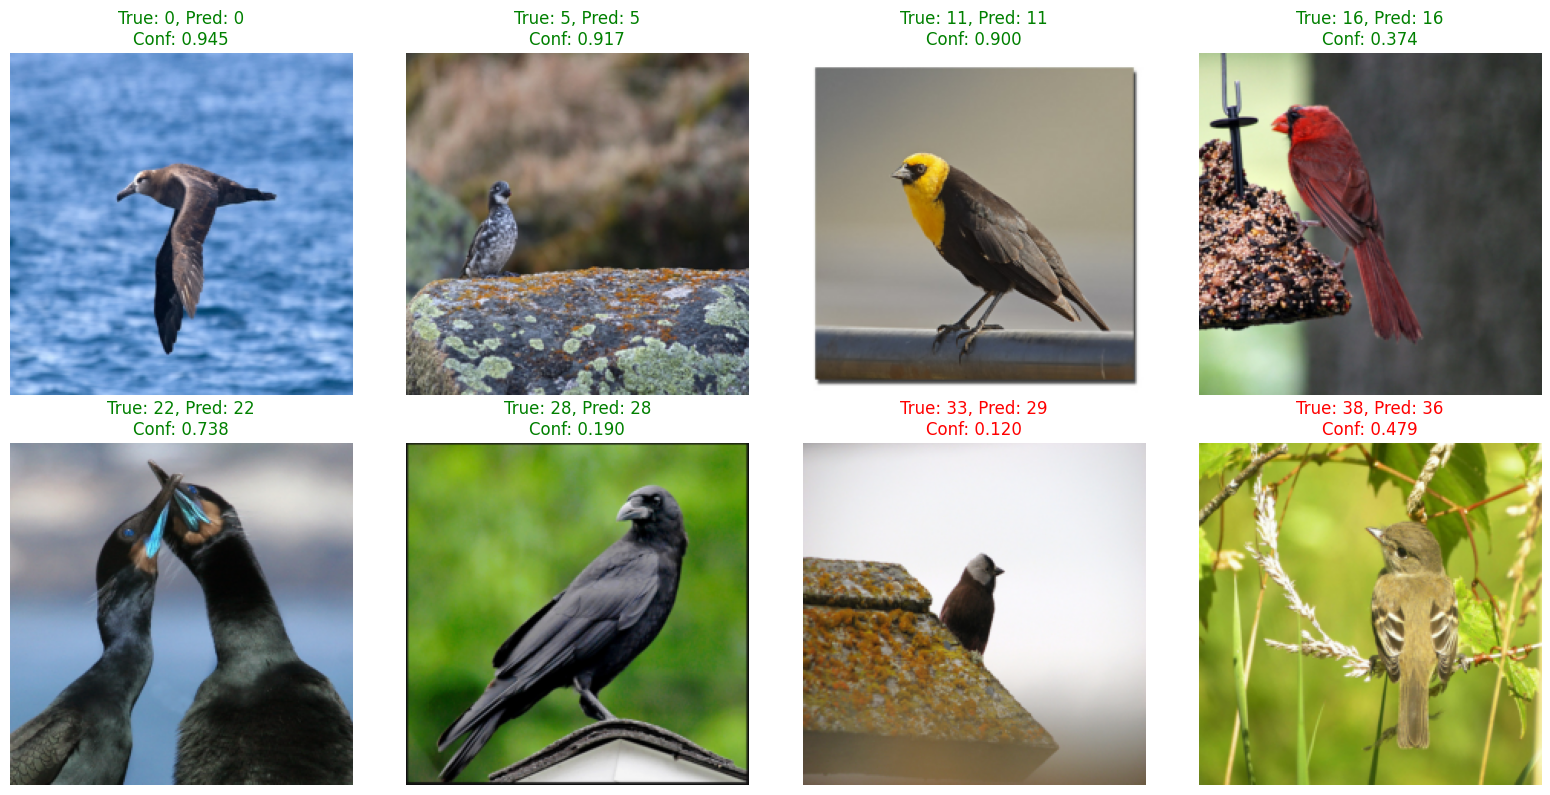

In [ ]:
# Display sample predictions
def show_sample_predictions(model, val_loader, device, num_samples=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            if i >= num_samples:
                break

            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)

            # Get first image from batch
            img = data[0].cpu()
            true_label = target[0].cpu().item()
            pred_label = predicted[0].cpu().item()
            confidence = torch.softmax(output[0], 0)[pred_label].cpu().item()

            # Denormalize image for display
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)

            axes[i].imshow(img.permute(1, 2, 0))
            axes[i].set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.3f}',
                            color='green' if true_label == pred_label else 'red')
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(RESULTS_PATH + 'sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

show_sample_predictions(model, val_loader, device)